In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# Feature extraction and spatial analysis

In [2]:
import lazyslide as zs

/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/timm/models/hub.py:4: FutureWarning: Importing from timm.models.hub is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


WSI: /Users/yzheng/Library/Caches/lazyslide/lung_carcinoma.ndpi
Reader: openslide
Dimensions: 15616×16384 (h×w), 8 Pyramids
Pixel physical size: 0.22731405710129116 MPP
SpatialData object
└── Images
      └── 'wsi_thumbnail': DataArray[cyx] (3, 1817, 1906)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images)
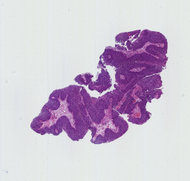

In [3]:
wsi = zs.datasets.lung_carcinoma(with_data=False)
wsi

Let's first find and tile the tissue

In [4]:
zs.pp.find_tissues(wsi)
zs.pp.tile_tissues(wsi, 128)

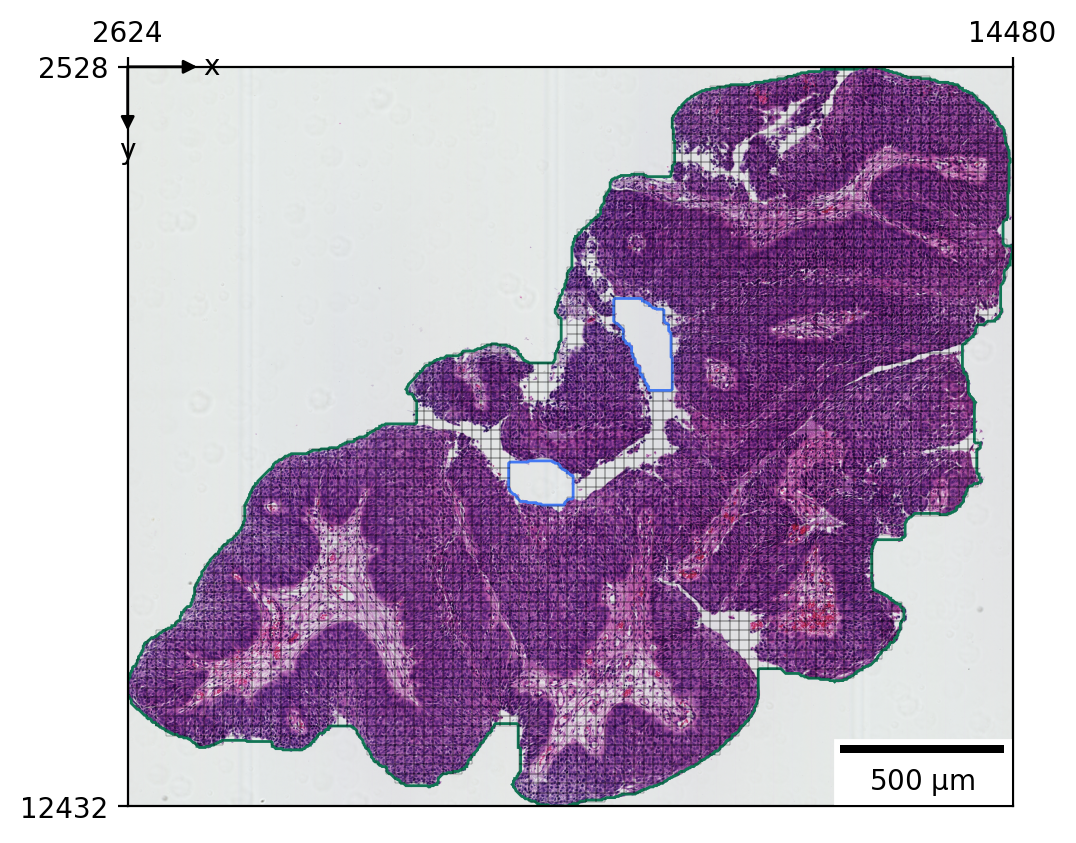

In [5]:
zs.pl.tiles(wsi, tissue_id=0)

## Morphological feature extraction

Feature extraction is to transform the image into a the numeric representation, which comprises of different morphological features. 

Typically, this is done by feeding the tiles into a vision model.

In [6]:
zs.tl.feature_extraction(wsi, "resnet50")

Output()

You can easily use foundational models in LazySlide by specifying the name:

Currently supported: 'uni', 'uni2', 'conch', 'conch_vision', 'gigapath'

:::{note}
You may need to request access at the corresponding huggingface repository.

In [7]:
zs.tl.feature_extraction(wsi, "uni2")

Output()

Features are saved as `AnnData` store with a convention of "{model name}_{tiles key}".

For example, `resnet50_tiles` and `uni2_tiles`

WSI: /Users/yzheng/Library/Caches/lazyslide/lung_carcinoma.ndpi
Reader: openslide
Dimensions: 15616×16384 (h×w), 8 Pyramids
Pixel physical size: 0.22731405710129116 MPP
SpatialData object
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1817, 1906)
├── Shapes
│     ├── 'tiles': GeoDataFrame shape: (3942, 5) (2D shapes)
│     └── 'tissues': GeoDataFrame shape: (1, 2) (2D shapes)
└── Tables
      ├── 'resnet50_tiles': AnnData (3942, 2048)
      └── 'uni2_tiles': AnnData (3942, 1536)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), tiles (Shapes), tissues (Shapes)
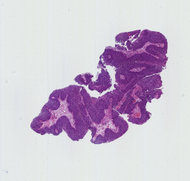

In [8]:
wsi

## Feature aggregation

To perform analysis across dataset, a usual way is to pool features into a 1D vector that can represent the entire slide. 

In [9]:
zs.tl.feature_aggregation(wsi, "uni2", by="slide")

In [10]:
wsi["uni2_tiles"]

AnnData object with n_obs × n_vars = 3942 × 1536
    obs: 'tile_id', 'library_id'
    uns: 'spatialdata_attrs', 'agg_ops'
    varm: 'agg_slide'

You can retrieve specific feature with the `fetch` accessor. This will return a copy of the anndata.

In [11]:
adata = wsi.fetch.features_anndata("uni2")

## Identification of spatial domains

If you have experience with scRNA-seq data, the following process should be quite familiar with you.

In [12]:
import scanpy as sc

In [58]:
adata = wsi["uni2_tiles"]
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
for res in [1.0, 0.5, 0.2]:
    sc.tl.leiden(adata, flavor="igraph", resolution=res, key_added=f"leiden_{res}")

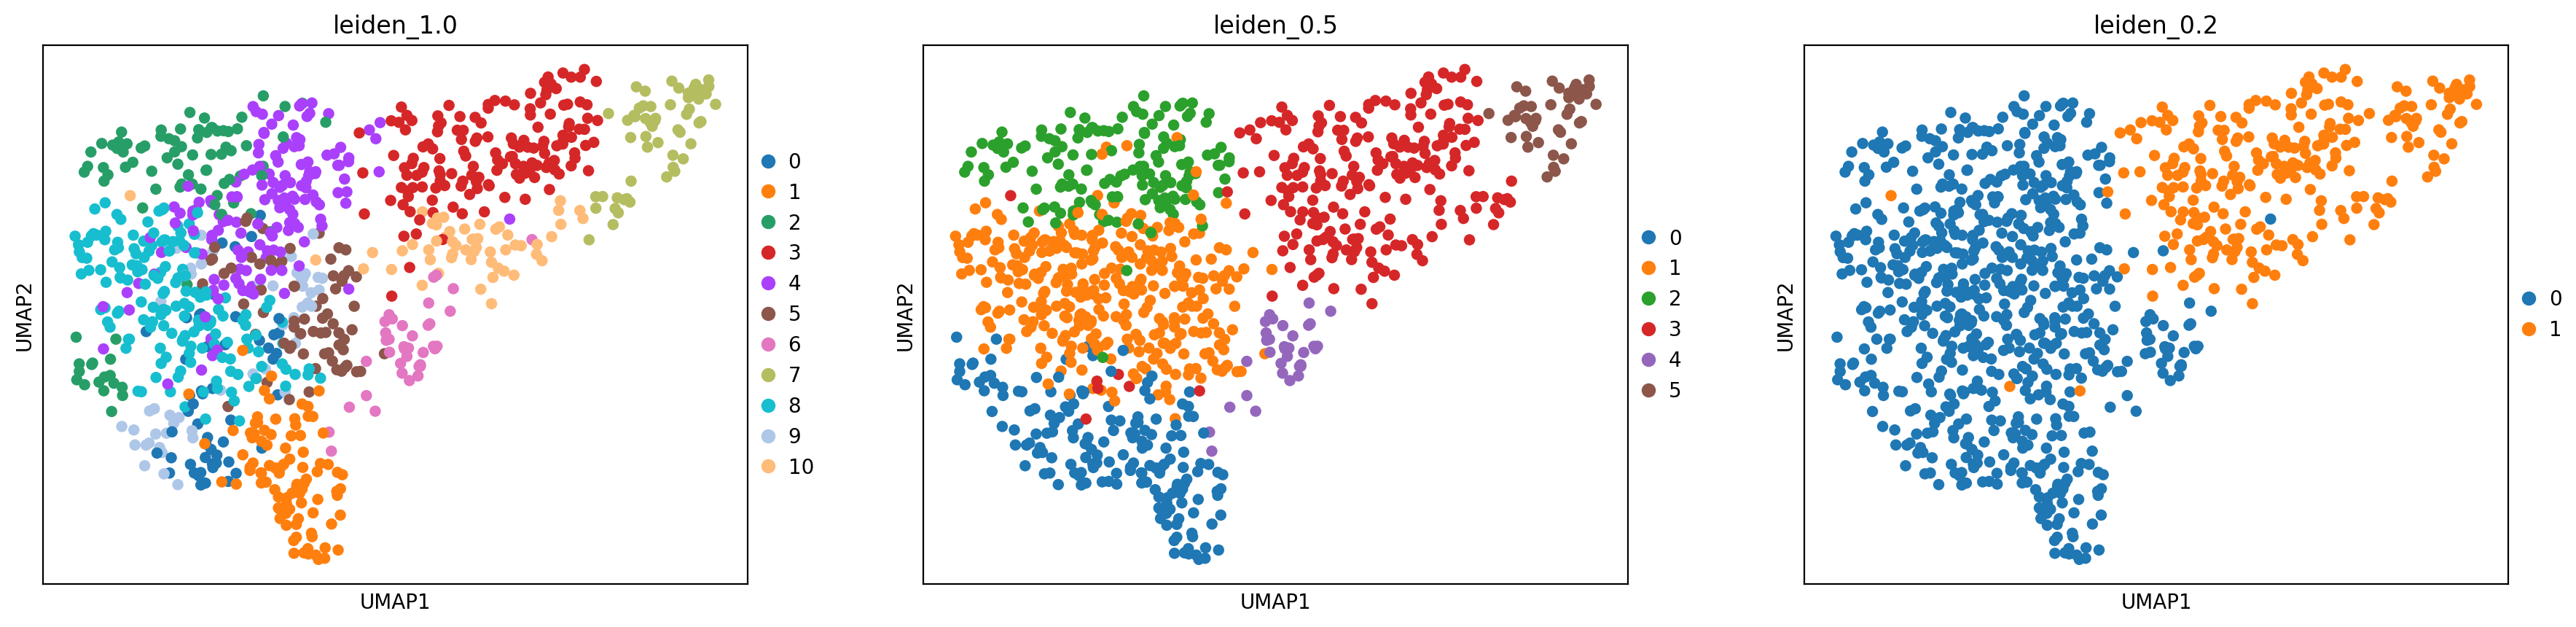

In [59]:
keys = ["leiden_1.0", "leiden_0.5", "leiden_0.2"]
sc.pl.umap(adata, color=keys)

In [60]:
sc.tl.rank_genes_groups(adata, groupby="leiden_0.2")

/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


In [61]:
names = sc.get.rank_genes_groups_df(adata, "0").names
features = list(names[0:10]) + list(names[-10:])

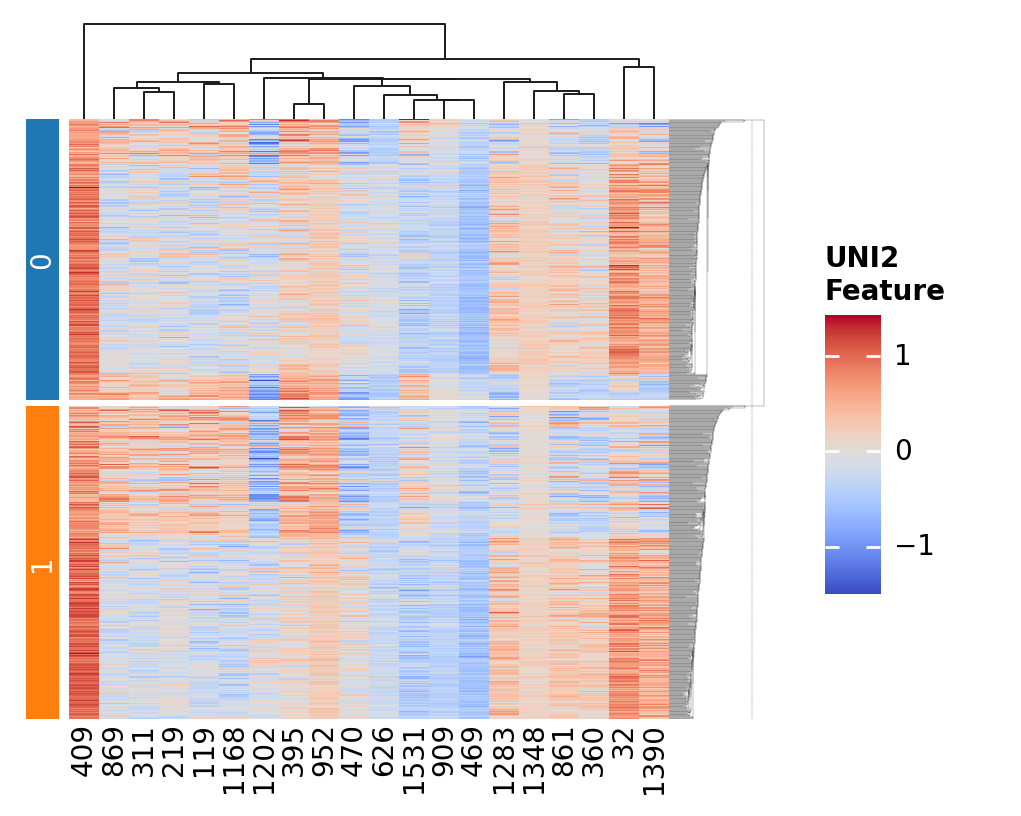

In [72]:
import marsilea as ma
import marsilea.plotter as mp
from scipy.stats import zscore

h = ma.Heatmap(adata[:, features].X, height=3, width=3, label="UNI2\nFeature")
order = sorted(adata.obs["leiden_0.2"].unique())
h.group_rows(adata.obs["leiden_0.2"], order=order)
h.add_left(mp.Chunk(order, fill_colors=["C0", "C1"], padding=2), pad=0.05)
h.add_bottom(mp.Labels(features))
h.add_dendrogram("right", linewidth=0.1)
h.add_dendrogram("top")
h.add_legends()
h.render()

/Users/yzheng/Projects/LazySlide/src/lazyslide/plotting/_wsi_viewer.py:1159: UserWarning: n_categories (11) for color_by=leiden_1.0 is greater than the n_colors (9).Duplicated colors will be used.
  warnings.warn(


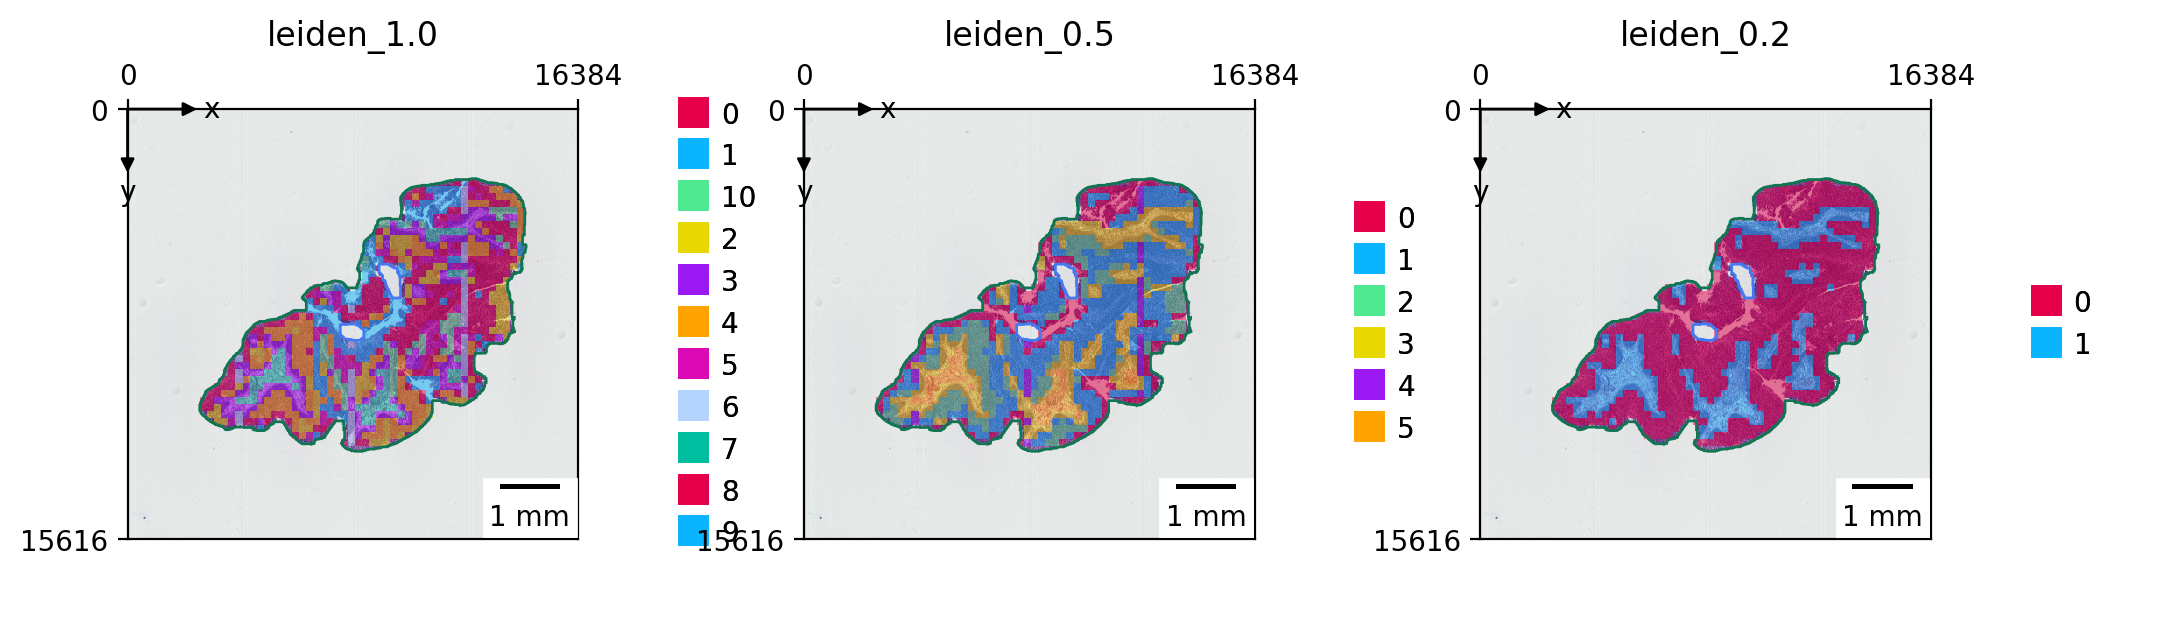

In [63]:
zs.pl.tiles(wsi, feature_key="uni2", color=keys, alpha=0.5)

## UTAG

[UTAG](https://doi.org/10.1038/s41592-022-01657-2) is a method develop to discovery spatial domain with unsupervised learning

In [64]:
zs.pp.tile_graph(wsi)
zs.tl.feature_utag(wsi, "uni2")

In [65]:
sc.pp.pca(adata, layer="utag")
sc.pp.neighbors(adata)
sc.tl.umap(adata)
for res in [1.0, 0.5, 0.2]:
    sc.tl.leiden(adata, flavor="igraph", resolution=res, key_added=f"leiden_{res}")

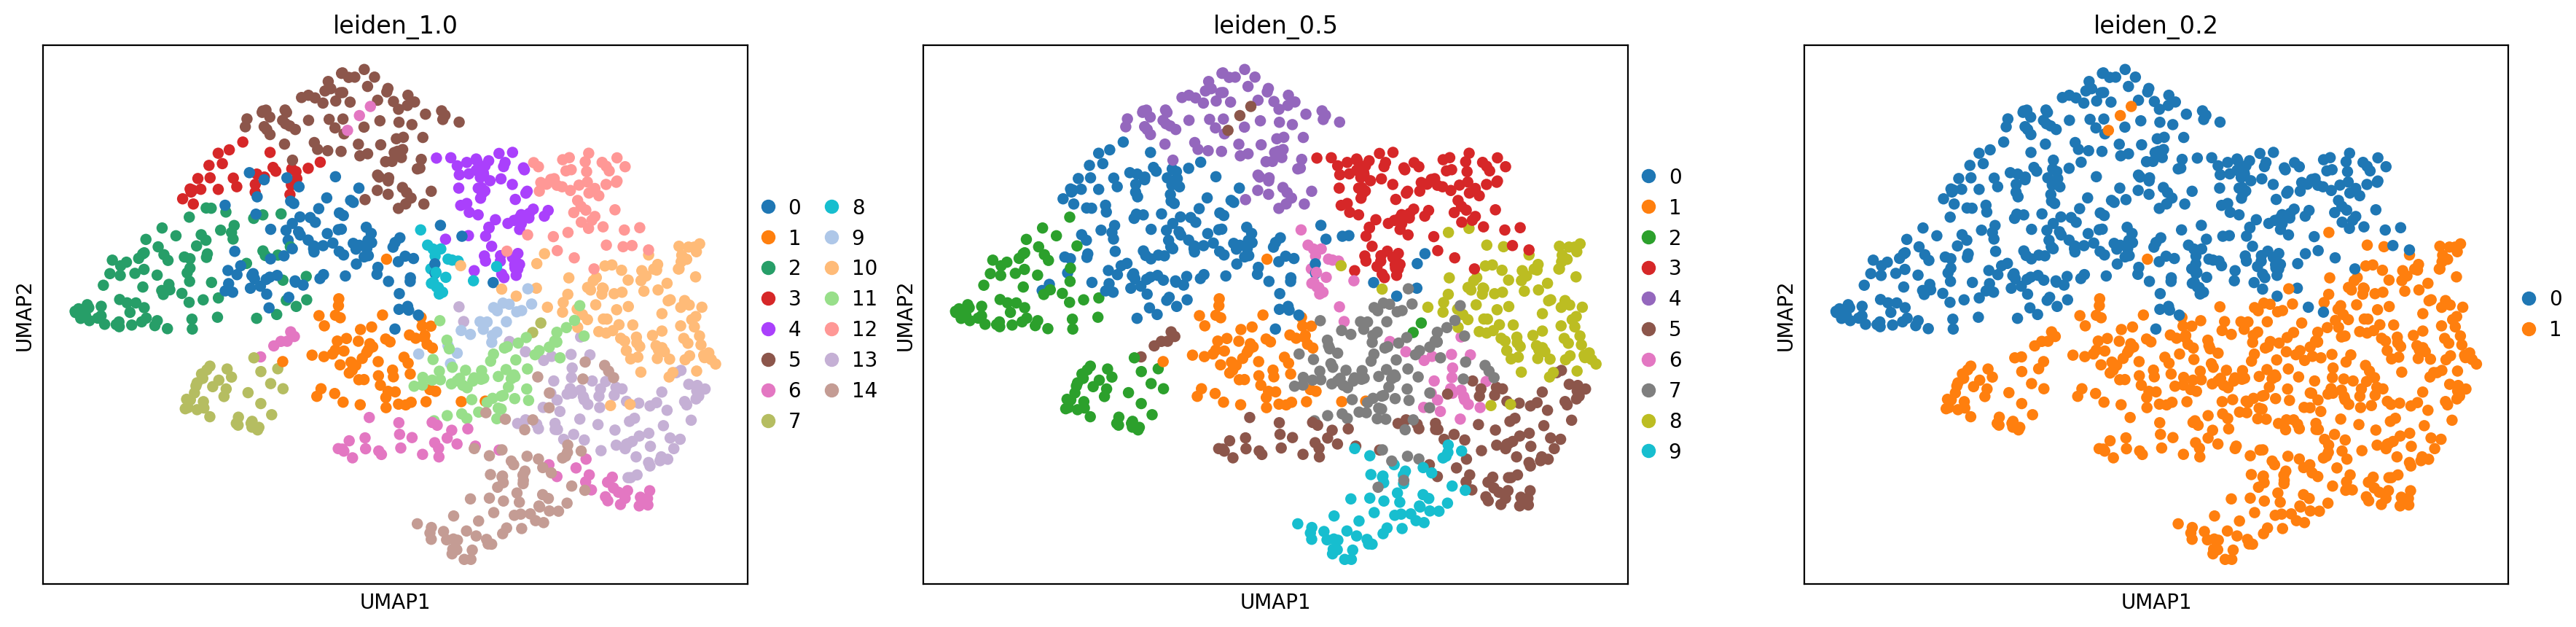

In [66]:
keys = ["leiden_1.0", "leiden_0.5", "leiden_0.2"]
sc.pl.umap(adata, color=keys)

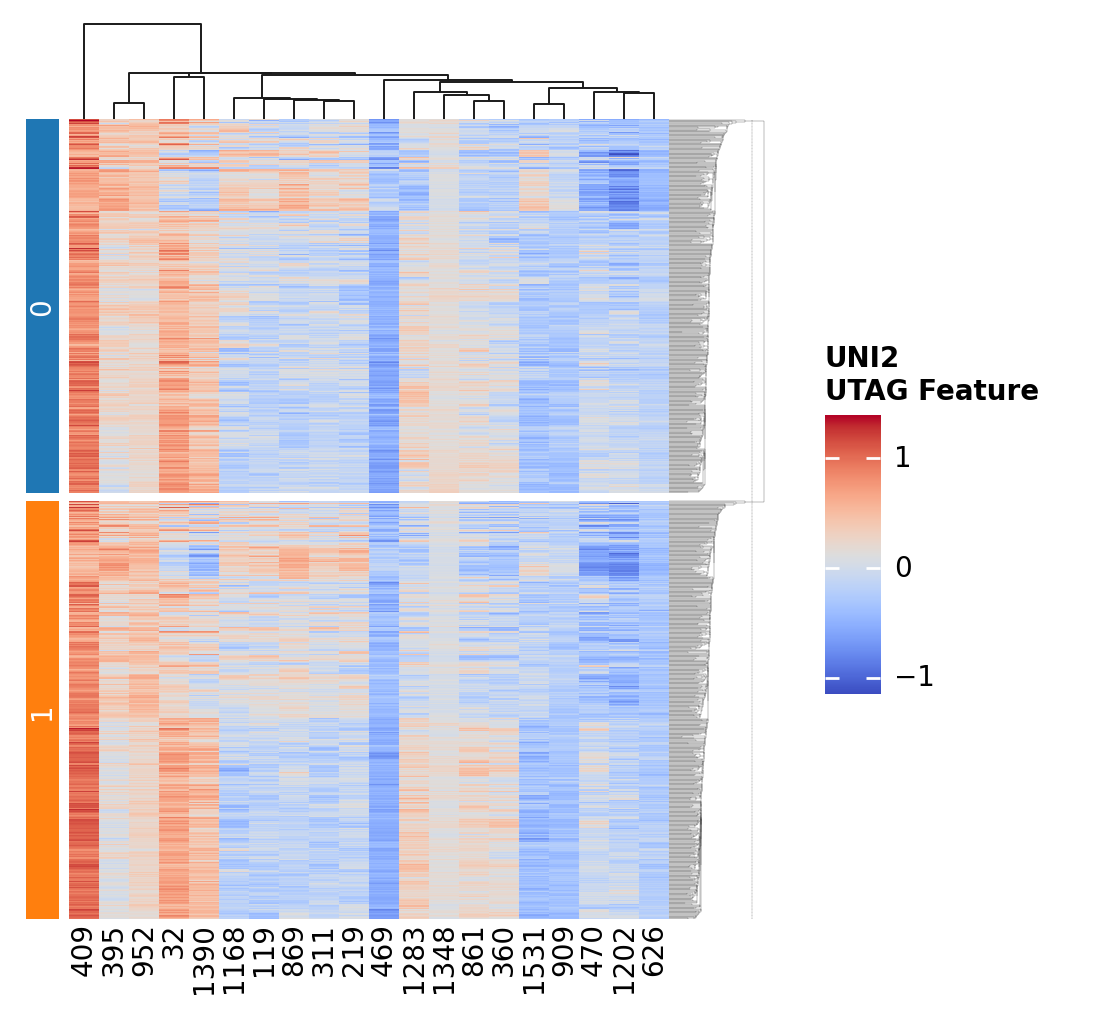

In [69]:
h = ma.Heatmap(adata[:, features].layers["utag"], width=3, label="UNI2\nUTAG Feature")
order = sorted(adata.obs["leiden_0.2"].unique())
h.group_rows(adata.obs["leiden_0.2"], order=order)
h.add_left(mp.Chunk(order, fill_colors=["C0", "C1"], padding=2), pad=0.05)
h.add_bottom(mp.Labels(features))
h.add_dendrogram("right", linewidth=0.1)
h.add_dendrogram("top")
h.add_legends()
h.render()

/Users/yzheng/Projects/LazySlide/src/lazyslide/plotting/_wsi_viewer.py:1159: UserWarning: n_categories (15) for color_by=leiden_1.0 is greater than the n_colors (9).Duplicated colors will be used.
  warnings.warn(
/Users/yzheng/Projects/LazySlide/src/lazyslide/plotting/_wsi_viewer.py:1159: UserWarning: n_categories (10) for color_by=leiden_0.5 is greater than the n_colors (9).Duplicated colors will be used.
  warnings.warn(


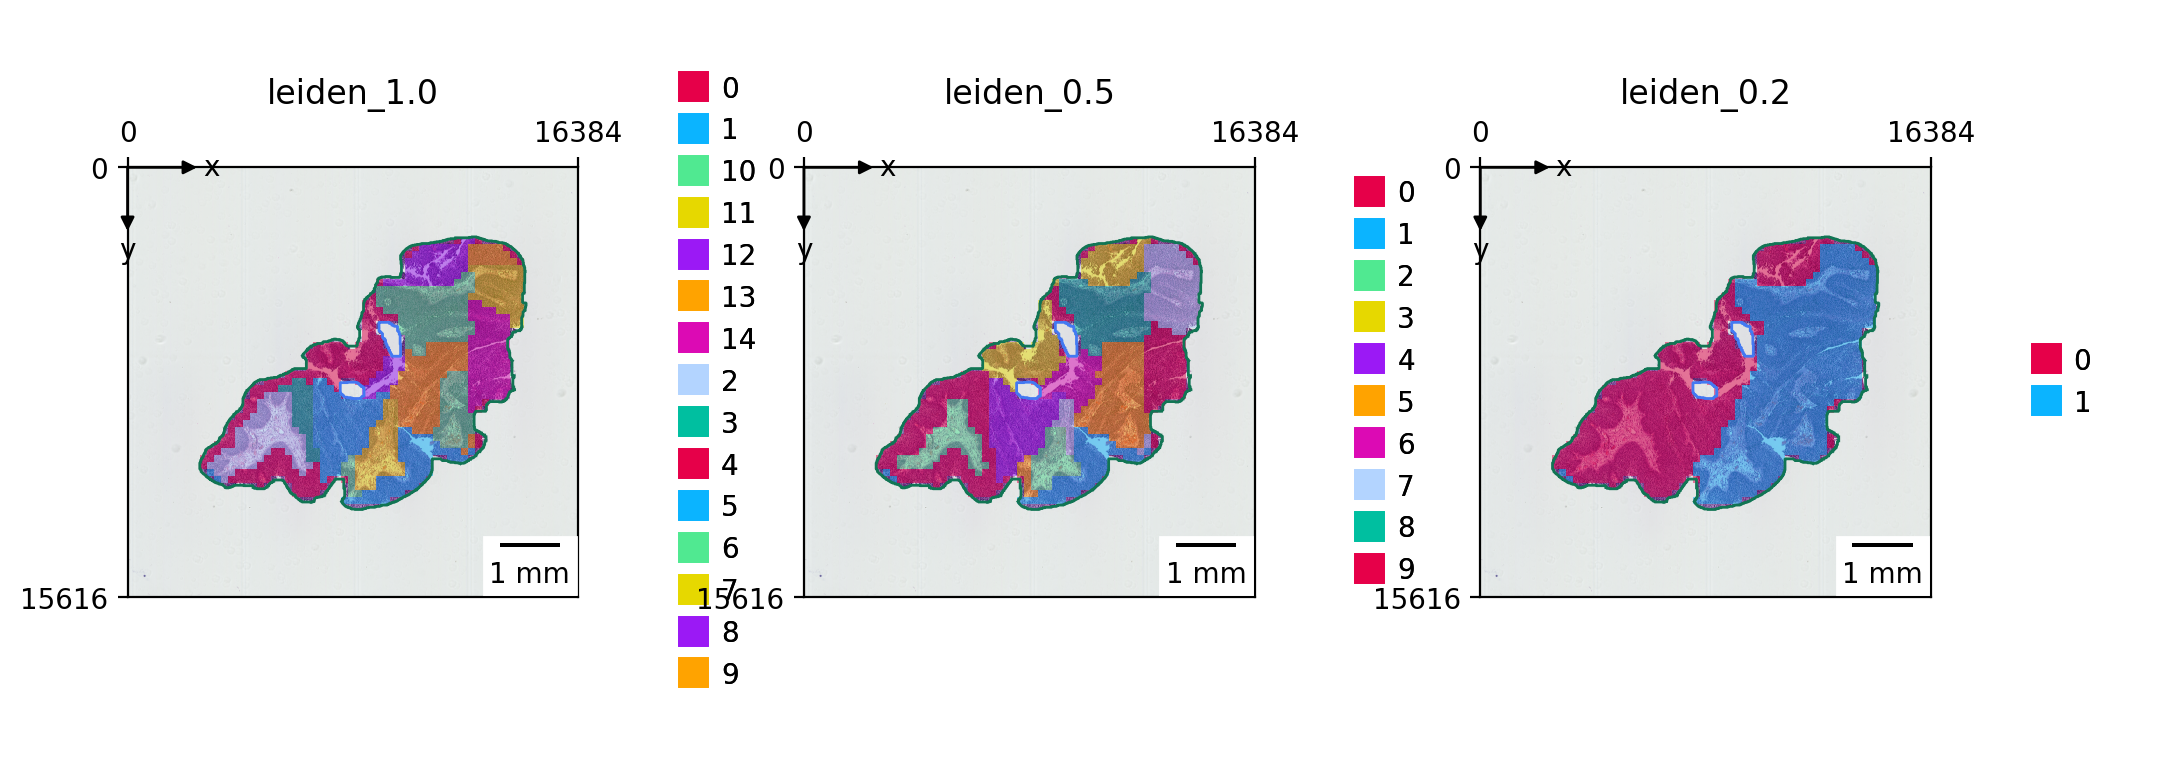

In [71]:
zs.pl.tiles(wsi, feature_key="uni2", color=keys, alpha=0.5)

## Text feature extraction

Apart from deriving morphological features from vision models, you can also run multimodal to derive text features.

Currently, there are two vision-language models for pathology
- [PLIP](https://doi.org/10.1038/s41591-023-02504-3), Nature Medicine, 2023
- [CONCH](https://doi.org/10.1038/s41591-024-02856-4), Nature Medicine, 2024

In [6]:
zs.tl.feature_extraction(wsi, "plip", device="mps")

Output()

In [7]:
terms = [
    # "tumor region", "normal epithelium", "necrotic area", "immune infiltration",
    # "fibrosis", "blood vessel", "lymphatic vessel", "bronchus", "alveolar space",
    # "inflammatory cells", "pleura", "connective tissue", "stroma",
    # "cancer-associated fibroblasts", "tumor margin", "invasive front",
    # "lymphoid aggregate", "fibroblast activation", "angiogenesis",
    # "tumor budding", "epithelial-mesenchymal transition",
    # "tumor nest", "perivascular region", "desmoplastic reaction",
    # "lepidic pattern", "acinar pattern", "papillary pattern", "solid pattern",
    # "micropapillary pattern", "spindle cells", "mucinous differentiation",
    # "squamous differentiation", "necrotic debris", "vascular invasion",
    # "pleural invasion", "bronchiole involvement", "tumor emboli", "keratin pearls",
    # "tumor infiltrating lymphocytes", "granuloma", "hemorrhage", "fibrin deposition"
    "tumor",
    "stroma",
    "lung tumor",
    "regressive carcinoma in situ lesions",
    "dark",
    "light",
]

embeddings = zs.tl.text_embedding(terms, model="plip")

In [8]:
zs.tl.text_image_similarity(wsi, embeddings)

In [ ]:
zs.pl.tiles(
    wsi,
    feature_key="plip_tiles_text_similarity",
    color=terms,
    cmap="Blues",
    show_image=False,
)